# Project on Policing using Predictive Models - By Amandeep Yadav

## Imports

In [541]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor
import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

## Data Preparation

### Read Dataset Files - 2018 will be train dataset and 2019 will be test dataset

In [542]:
crime18 = pd.read_csv('2018.csv')
crime19 = pd.read_csv('2019.csv')

### Add the zipcode column to 2018 data using coordinates from Dataset

In [543]:
crime18['geometry'] = crime18.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
geo_police_data = geopandas.GeoDataFrame(crime18, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}
sf = geopandas.read_file('zipcodes_geo.json')
sf.crs = {'init': 'epsg:4326'}
sf = sf.set_geometry('geometry')
crime18 = geopandas.tools.sjoin(geo_police_data, sf, how='left')

### Refining DateTime for 2018

In [544]:
day_time_zip_18 = crime18[['Incident Date', 'Incident Day of Week', 'Incident Time', 'zip']]
day_time_zip_18.loc[:, 'Date'] = pd.to_datetime(day_time_zip_18['Incident Date'], dayfirst=True)
day_time_zip_18.loc[:, 'Hour'] = pd.to_datetime(day_time_zip_18['Incident Time'])
day_time_zip_18.loc[:, 'Hour'] = day_time_zip_18.Hour.apply(lambda x: x.hour)
day_time_zip_18.head()

,Incident Date,Incident Day of Week,Incident Time,zip,Date,Hour
0,01-01-2018,Monday,00:00,94132,2018-01-01,0
1,01-01-2018,Monday,00:00,94115,2018-01-01,0
2,01-01-2018,Monday,00:00,94158,2018-01-01,0
3,01-01-2018,Monday,00:00,94158,2018-01-01,0
4,01-01-2018,Monday,00:00,94131,2018-01-01,0


### Slicing Dataset and obtaining necessary data from 2018

In [546]:
day_time_zip_18_final = day_time_zip_18[['Incident Day of Week', 'zip', 'Hour']]
day_time_zip_18_final.loc[:, 'Crimes'] = 1
hour_totals_18 = day_time_zip_18_final.groupby(['Incident Day of Week', 'zip', 'Hour']).sum().reset_index()
hour_totals_18.sort_values('Crimes', ascending = False).head()

,Incident Day of Week,zip,Hour,Crimes
3806,Wednesday,94103,13,233
3180,Tuesday,94103,12,211
3183,Tuesday,94103,15,209
3809,Wednesday,94103,16,204
3805,Wednesday,94103,12,202


### Creating dummies

In [547]:
hour_totals_18 = hour_totals_18[['Crimes', 'Hour', 'Incident Day of Week', 'zip']]
totals_dummies_18 = pd.get_dummies(hour_totals_18)
X_18 = totals_dummies_18.iloc[:, 1:]
y_18 = totals_dummies_18.iloc[:, 0]

### Add the zipcode column to 2019 data using coordinates from Dataset

In [548]:
crime19['geometry'] = crime19.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
geo_police_data = geopandas.GeoDataFrame(crime19, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}
sf = geopandas.read_file('zipcodes_geo.json')
sf.crs = {'init': 'epsg:4326'}
sf = sf.set_geometry('geometry')
crime19 = geopandas.tools.sjoin(geo_police_data, sf, how='left')

### Refining DateTime for 2019

In [549]:
day_time_zip_19 = crime19[['Incident Day of Week', 'Incident Time', 'zip']]
day_time_zip_19['Hour'] = pd.to_datetime(day_time_zip_19['Incident Time'])
day_time_zip_19['Hour'] = day_time_zip_19.Hour.apply(lambda x: x.hour)
day_time_zip_19 = day_time_zip_19[['Incident Day of Week', 'zip', 'Hour']]
day_time_zip_19['Crimes'] = 1
hour_totals_19 = day_time_zip_19.groupby(['Incident Day of Week', 'zip', 'Hour']).count().reset_index()
hour_totals_19.sort_values('Crimes', ascending = False).head()

,Incident Day of Week,zip,Hour,Crimes
3164,Tuesday,94103,12,205
657,Monday,94103,12,204
3790,Wednesday,94103,13,198
3167,Tuesday,94103,15,194
3791,Wednesday,94103,14,189


### Slicing Dataset and obtaining necessary data from 2019

In [550]:
hour_totals_19 = hour_totals_19[['Crimes', 'Hour', 'Incident Day of Week', 'zip']]
totals_dummies_19 = pd.get_dummies(hour_totals_19)
X_19 = totals_dummies_19.iloc[:, 1:]
y_19 = totals_dummies_19.iloc[:, 0]

## Applying Models

### Linear Regression

In [551]:
linear_regression = LinearRegression()
linear_regression.fit(X_18,y_18)
linear_regression.score(X_19, y_19)

0.7092275201549754

### Random Forest

In [552]:
rf = RandomForestRegressor()
rf.fit(X_18, y_18)
rf.score(X_19,y_19)

0.9028260307536421

### K - Nearest Neighbours

In [553]:
knn = KNeighborsRegressor()
knn.fit(X_18, y_18)
knn.score(X_19,y_19)

0.7475815287895347

### XGBoost

In [554]:
xgb = XGBRegressor()
xgb.fit(X_18, y_18)
xgb.score(X_19,y_19)

0.9112321167164109

### Multilayer Perceptron

In [555]:
mlp = MLPRegressor(hidden_layer_sizes = (100,100,100,100), random_state=444)
mlp.fit(X_18,y_18)
mlp.score(X_19, y_19)

0.9124238227452515

## Refining Results

### Adding the predictions as columns to the data

In [556]:
mlp_predicts = mlp.predict(X_18)
xgb_predicts = xgb.predict(X_18)
hour_totals_19['Predicted_mlp'] = pd.Series(mlp_predicts)
hour_totals_19['Predicted_xgb'] = pd.Series(xgb_predicts)

### Divide by 365 to get per day basis

In [557]:
hour_totals_19['Crimes'] = hour_totals_19['Crimes']/365
hour_totals_19['Predicted_mlp'] = hour_totals_19['Predicted_mlp']/365
hour_totals_19['Predicted_xgb'] = hour_totals_19['Predicted_xgb']/365

### Round off the values

In [558]:
hour_totals_19 = np.round(hour_totals_19,2)

### Save the results to a file

In [559]:
hour_totals_19.to_json("./new_crime_predictions.json", orient='records', double_precision=2)

### Sanity Check using chloropleth

<Axes: >

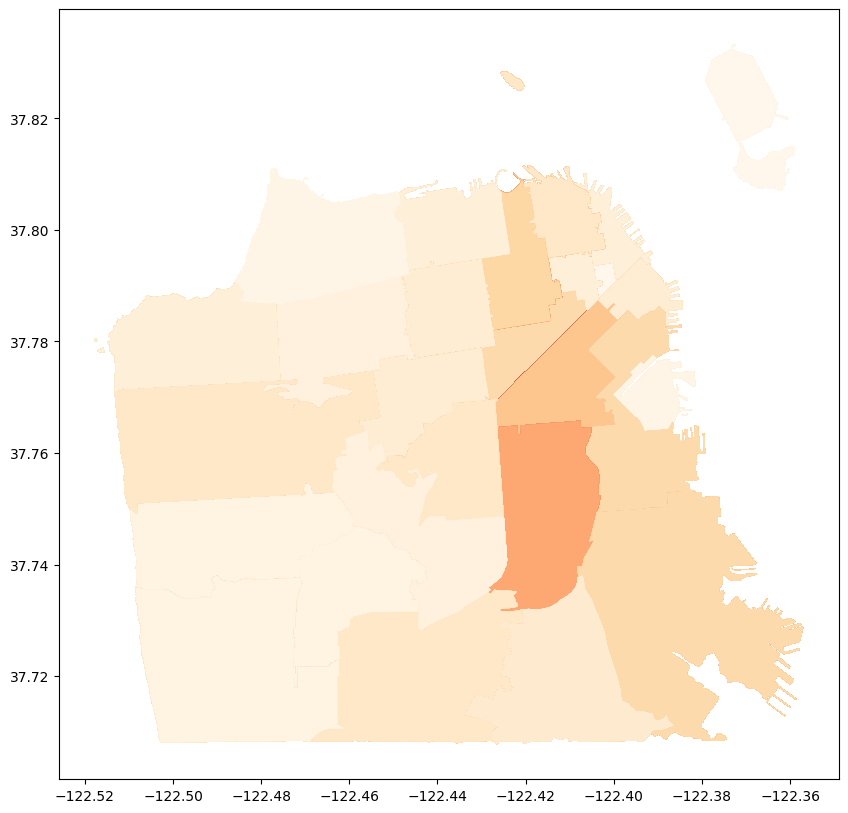

In [560]:
chloropleth_data = hour_totals_19.merge(sf)
chloropleth_data = geopandas.GeoDataFrame(chloropleth_data, geometry='geometry')
chloropleth_data.crs = {'init': 'epsg:4326'}
chloropleth_data.plot(column='Crimes', cmap='OrRd', figsize=(13,10))

## Analysis

### Check on Data

In [561]:
hour_totals_19.head()

,Crimes,Hour,Incident Day of Week,zip,Predicted_mlp,Predicted_xgb
0,0.26,0,Friday,94102,0.30,0.29
1,0.18,1,Friday,94102,0.09,0.12
2,0.14,2,Friday,94102,0.07,0.09
3,0.13,3,Friday,94102,0.06,0.07
4,0.06,4,Friday,94102,0.06,0.06


### Confusion Matrix

In [564]:
threshold = 0.18

crimes_actual = np.array([d[0] for d in hour_totals_19.iloc])
crimes_predicted = np.array([d[4] for d in hour_totals_19.iloc])

labels_actual = crimes_actual >= threshold
labels_predicted = crimes_predicted >= threshold

confusion = confusion_matrix(labels_actual, labels_predicted)
confusion_df = pd.DataFrame(confusion, index=['Actual < threshold', 'Actual >= threshold'], columns=['Predicted < threshold', 'Predicted >= threshold'])
print(confusion_df)

                     Predicted < threshold  Predicted >= threshold
Actual < threshold                    3597                     242
Actual >= threshold                    305                     236


### Classification Report - Precision, Recall, F1-score

In [565]:
from sklearn.metrics import classification_report
print(classification_report(labels_actual, labels_predicted))

              precision    recall  f1-score   support

       False       0.92      0.94      0.93      3839
        True       0.49      0.44      0.46       541

    accuracy                           0.88      4380
   macro avg       0.71      0.69      0.70      4380
weighted avg       0.87      0.88      0.87      4380



### ROC Curve

Text(0, 0.5, 'True Positive Rate')

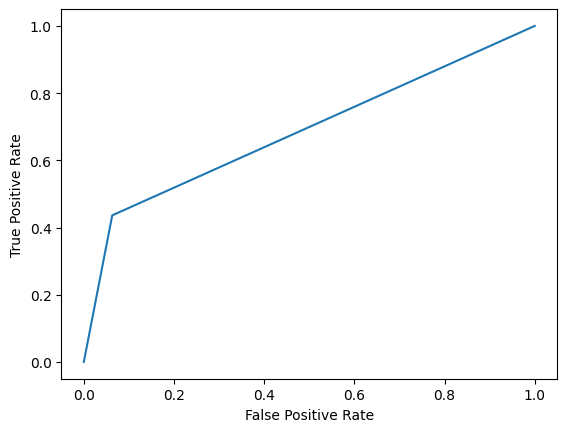

In [566]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels_actual, labels_predicted)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Precision Recall Curve

Text(0, 0.5, 'Precision')

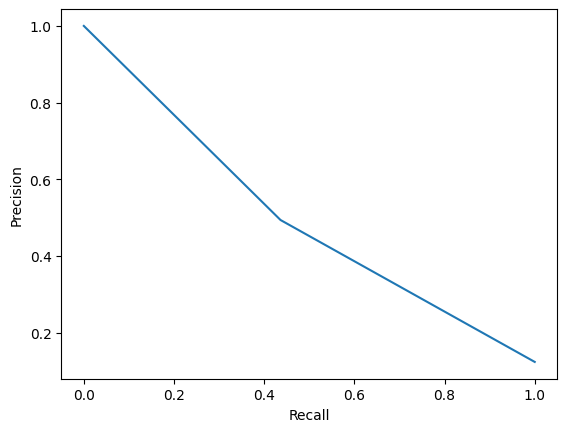

In [567]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(labels_actual, labels_predicted)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')